# Continuously tempered Hamiltonian Monte Carlo

This notebook runs implements and recreates figure 1 from https://arxiv.org/pdf/1704.03338

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpyro
import numpyro.distributions as dist
import numpyro.infer.util

import jax
import jax.numpy as jnp
import jax.flatten_util

import optax

import matplotlib.pyplot as plt
import arviz as az

from functools import partial
from CT_HMC_wrappers import (
    wrap_model,
    re_center_guide,
    nlogZ
)

numpyro.set_host_device_count(4)

## Making the model

We will make a multimodal distribution as a mixture of two Normal distributions that are far apart that we would like to draw samples from.

In [3]:
mu = jnp.array([-8.0, 8.0])
sigma = jnp.array([1.0, 2.0])
p = jnp.array([0.6, 0.4])


def model():
    mixing_dist = dist.Categorical(probs=p)
    mixture = dist.MixtureSameFamily(
        mixing_dist,
        dist.Normal(loc=mu, scale=sigma)
    )
    numpyro.sample('x', mixture)

## NUTS on its own

As a first test let's see how NUTS does.

In [4]:
rng_key = jax.random.PRNGKey(0)
nuts_key, rng_key = jax.random.split(rng_key)

num_chains = 4

nuts_kernel = numpyro.infer.NUTS(
    model,
    target_accept_prob=0.99,
    max_tree_depth=10,
    dense_mass=True
)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=5000,
    num_chains=num_chains,
    chain_method='parallel',
    progress_bar=True,
)
mcmc.run(nuts_key)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,4.01,7.135,-9.242,11.302,3.459,2.637,7.0,29.0,1.53


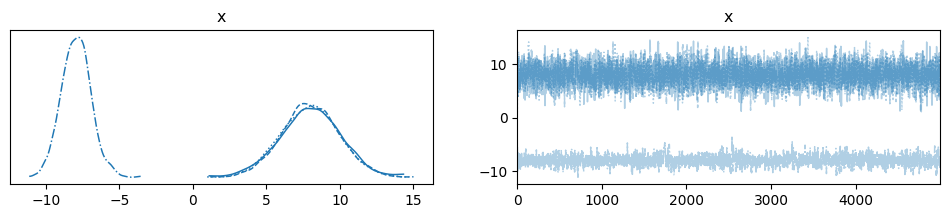

In [5]:
inf_nuts = az.from_numpyro(mcmc)

print(inf_nuts.sample_stats.diverging.data.sum(axis=1))
display(az.summary(inf_nuts))
az.plot_trace(inf_nuts);

We can see that NUTS on its own picks up only one of the peaks, with different chains potentially finding different peaks.

## CTHMC

Now let's trying with CTHMC.  This needs a normalized "hight temperature" distribution to use as a "base".  To find this base we will use SVI with an "AutoDiagonalNormal" guide.  Importantly, we want to make sure the guide is large enough to cover all the peaks.  For this simple case I found using the `RenyiELBO` does a better job of landing between the two peaks rather than fitting just one.  

Note: Section 6 explicitly mentions using the Rényi divergence for SVI for exactly this reason.

In [6]:
sub_key, svi_key, rng_key = jax.random.split(rng_key, 3)

100%|██████████| 20000/20000 [00:06<00:00, 3206.18it/s, init loss: 12.2355, avg. loss [19001-20000]: 0.3399]


{'auto_loc': Array([-2.355901], dtype=float32),
 'auto_scale': Array([8.945302], dtype=float32)}

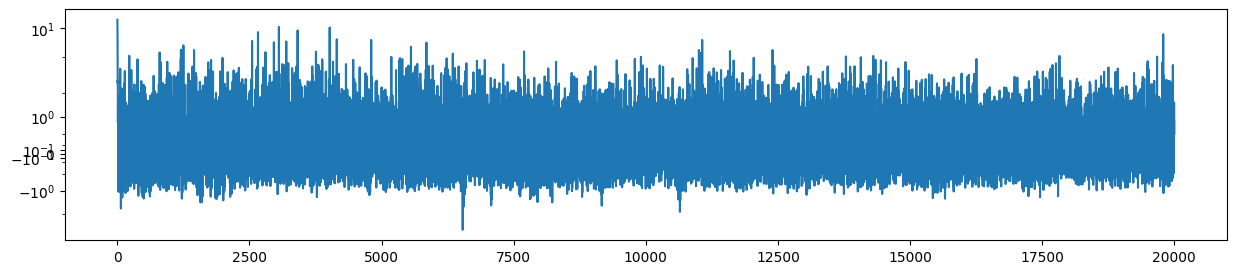

In [7]:
target_guide = numpyro.infer.autoguide.AutoDiagonalNormal(model)
scheduler1 = optax.exponential_decay(
    init_value=0.5,
    decay_rate=0.99,
    transition_steps=100
)

optim = optax.adabelief(learning_rate=scheduler1)
loss = numpyro.infer.RenyiELBO(alpha=0.1, num_particles=10)
svi = numpyro.infer.SVI(
    model,
    target_guide,
    optim,
    loss
)
svi_results = svi.run(
    svi_key,
    20000,
    progress_bar=True,
    stable_update=True
)

display(svi_results.params)
plt.figure(figsize=(15, 3))
plt.plot(svi_results.losses)
plt.gca().set_yscale('asinh');

Numpyro sign convention: the loss plotted above is the negative ELBO, the sign has been flipped from the paper in the code below to account for this.  Also NUTS needs the `potential_energy` function to return the negative potential energy of the system.  Again the sign has been flipped in the code below.

## Apply the wrappers

In [8]:
temp_model, potential_energy_fn, sample_init_fn, postprocessing_fn, neg_elbo = wrap_model(
    model,
    (),
    {},
    target_guide,
    svi_results=svi_results
)

In [9]:
mcmc_key, init_key, rng_key = jax.random.split(rng_key, 3)

Find initial positions for each chain.  Take these as draws from the SVI guide with `temp_ctrl` set to large negative values (e.g. the high temperature state).

In [10]:
num_chains = 4

unconstrained_init_params = sample_init_fn(init_key, svi_results.params, num_chains)

Run NUTS with the augmented model.  Because we are providing a `potential_fn` we must also provide the `init_params` and `postprocess_fn` by hand.

In [11]:
nuts_kernel = numpyro.infer.NUTS(
    potential_fn=potential_energy_fn,
    target_accept_prob=0.99,
    max_tree_depth=10,
    dense_mass=True
)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=5000,
    num_chains=num_chains,
    chain_method='parallel',
    progress_bar=True,
    postprocess_fn=postprocessing_fn
)
mcmc.run(
    mcmc_key,
    init_params=unconstrained_init_params
)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,-0.443,3.031,-2.209,3.845,0.040,0.029,1786.0,4585.0,1.01
inv_temp,0.555,0.304,0.057,1.000,0.005,0.003,4175.0,4812.0,1.00
temp_ctrl,0.319,1.985,-3.524,4.044,0.031,0.022,4175.0,4812.0,1.00
w0,1.157,2.553,0.273,3.929,0.032,0.022,1786.0,4585.0,1.01
w1,1.599,0.730,0.084,2.481,0.014,0.012,1786.0,4585.0,1.01
x,-0.250,7.945,-10.503,11.416,0.402,0.284,547.0,5396.0,1.01


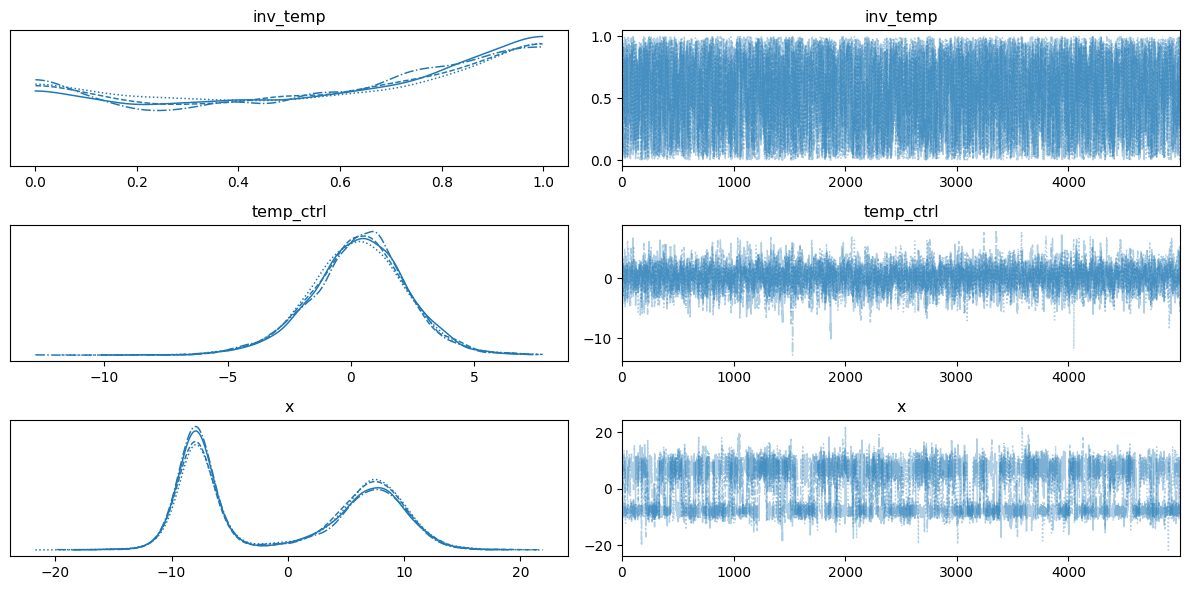

In [12]:
inf_data = az.from_numpyro(mcmc)

print(inf_data.sample_stats.diverging.data.sum(axis=1))
display(az.summary(inf_data))

az.plot_trace(inf_data, var_names=['inv_temp', 'temp_ctrl', 'x'])
plt.tight_layout();

We can see that `inv_temp` is close to uniform, this is a good sign that the process worked as expected.

Now let's recrate one of the panels of figure 1, `x` vs `inv_temp` with point size set to the `w1` weight (offset by 0.1 so all points are visible).

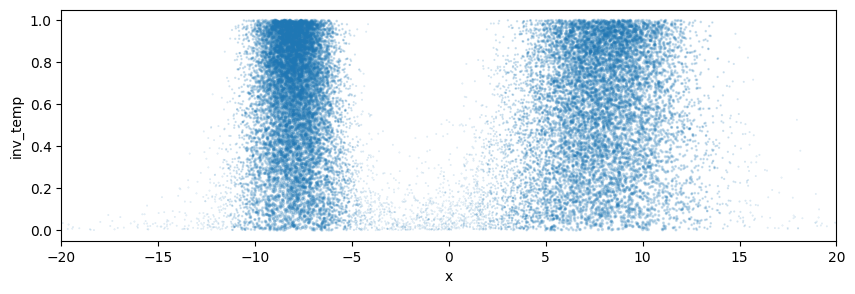

In [13]:
plt.figure(figsize=(10, 3))
plt.scatter(inf_data.posterior.x.data.flatten(), inf_data.posterior.inv_temp.data.flatten(), s=inf_data.posterior.w1.data.flatten() + 0.1, alpha=0.2)
plt.xlabel('x')
plt.ylabel('inv_temp')
plt.xlim(-20, 20);

Tempering gives us a way of calculating evidence!

In [14]:
neg_log_Z = nlogZ(neg_elbo, mcmc.get_samples())
print(f'-log_Evidence: {neg_log_Z}')
print(f'Evidence: {jnp.exp(-neg_log_Z)}')

-log_Evidence: 0.00286865234375
Evidence: 0.9971354603767395


## Iterate

Following the recommendation of section 6 we can use the solution of the previous mcmc chain as an input for a new one.

In [15]:
new_params, new_neg_elbo = re_center_guide(model, (), {}, mcmc, target_guide, neg_elbo)

In [16]:
new_params, new_neg_elbo

({'auto_loc': Array([-0.9228342], dtype=float32),
  'auto_scale': Array([8.06575], dtype=float32)},
 Array(0.00286865, dtype=float32))

In [17]:
temp_model_2, potential_energy_fn_2, sample_init_fn_2, postprocessing_fn_2, neg_elbo_2 = wrap_model(
    model,
    (),
    {},
    target_guide,
    neg_elbo=new_neg_elbo,
    guide_params=new_params
)

In [18]:
mcmc_key, init_key, rng_key = jax.random.split(rng_key, 3)

In [19]:
unconstrained_init_params_2 = sample_init_fn_2(init_key, new_params, num_chains)

nuts_kernel_2 = numpyro.infer.NUTS(
    potential_fn=potential_energy_fn_2,
    target_accept_prob=0.99,
    max_tree_depth=10,
    dense_mass=True
)

mcmc_2 = numpyro.infer.MCMC(
    nuts_kernel_2,
    num_warmup=1000,
    num_samples=5000,
    num_chains=num_chains,
    chain_method='parallel',
    progress_bar=True,
    postprocess_fn=postprocessing_fn_2
)
mcmc_2.run(
    mcmc_key,
    init_params=unconstrained_init_params_2
)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,0.041,3.141,-1.971,5.042,0.046,0.032,1641.0,6261.0,1.00
inv_temp,0.520,0.303,0.049,1.000,0.005,0.004,3567.0,4475.0,1.00
temp_ctrl,0.099,1.975,-3.692,3.706,0.033,0.023,3567.0,4475.0,1.00
w0,1.405,2.672,0.319,5.075,0.035,0.025,1641.0,6261.0,1.00
w1,1.365,0.703,0.033,2.290,0.016,0.014,1641.0,6261.0,1.00
x,-0.725,7.888,-10.837,11.305,0.399,0.282,559.0,5370.0,1.01


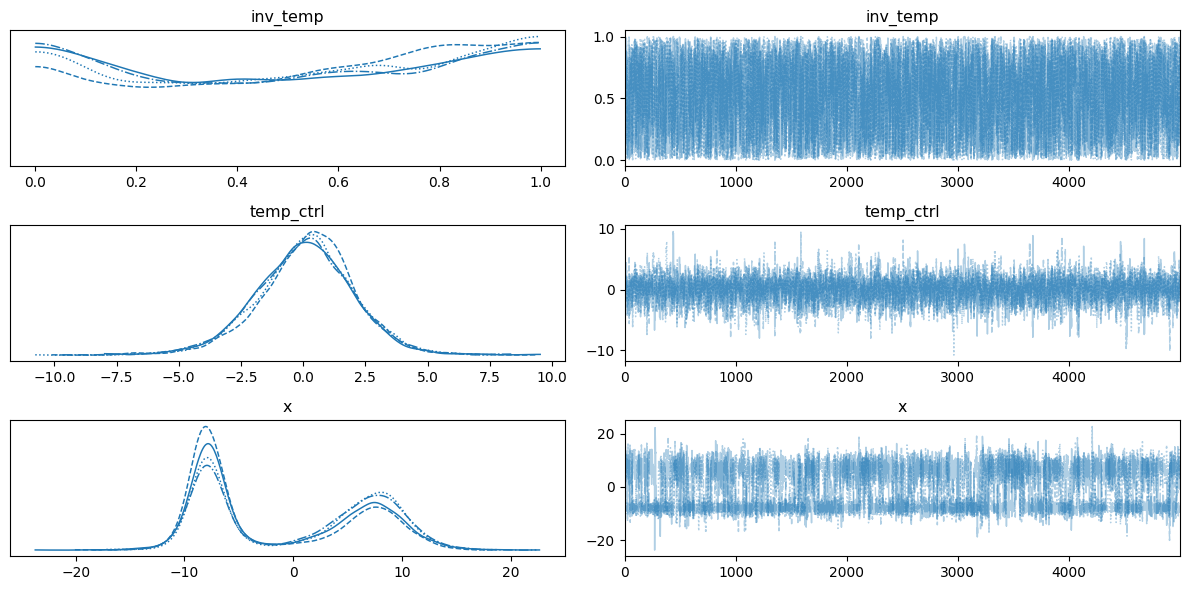

In [20]:
inf_data_2 = az.from_numpyro(mcmc_2)

print(inf_data_2.sample_stats.diverging.data.sum(axis=1))
display(az.summary(inf_data_2))

az.plot_trace(inf_data_2, var_names=['inv_temp', 'temp_ctrl', 'x'])
plt.tight_layout();

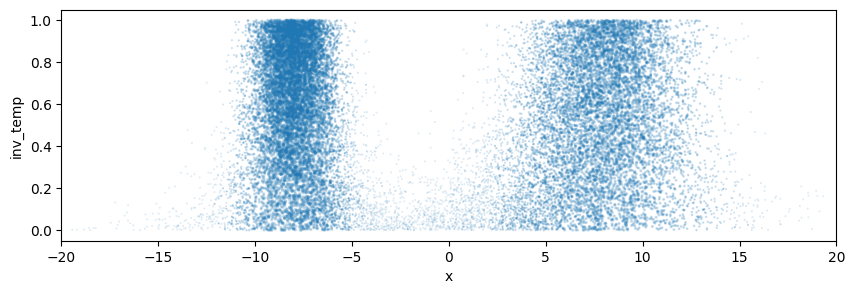

In [21]:
plt.figure(figsize=(10, 3))
plt.scatter(inf_data_2.posterior.x.data.flatten(), inf_data_2.posterior.inv_temp.data.flatten(), s=inf_data_2.posterior.w1.data.flatten() + 0.1, alpha=0.2)
plt.xlabel('x')
plt.ylabel('inv_temp')
plt.xlim(-20, 20);

In [22]:
neg_log_Z_2 = nlogZ(new_neg_elbo, mcmc_2.get_samples())
print(f'-log_Evidence: {neg_log_Z_2}')
print(f'Evidence: {jnp.exp(-neg_log_Z_2)}')

-log_Evidence: 0.032204627990722656
Evidence: 0.9683084487915039


Finally we can compare to the ground truth.

In [23]:
mixing_dist = dist.Categorical(probs=p)
D = dist.MixtureSameFamily(
    mixing_dist,
    dist.Normal(loc=mu, scale=sigma)
)

In [24]:
x = jnp.linspace(-20, 20, 1000)
y1 = jnp.exp(D.log_prob(x))
y2 = jnp.exp(target_guide.get_posterior(params=new_params).log_prob(x))

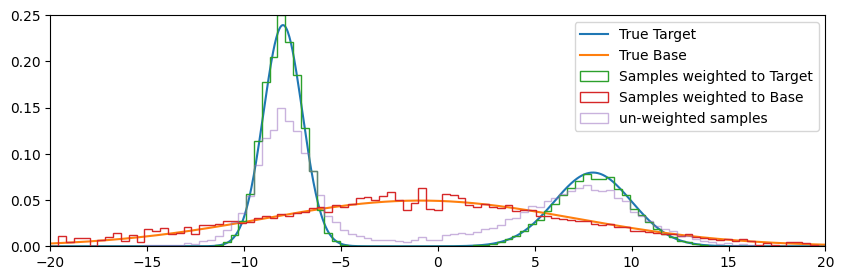

In [25]:
bins = jnp.linspace(-20, 20, 100)

x_data = inf_data_2.posterior.x.data.flatten()
w1 = inf_data_2.posterior.w1.data.flatten()
w0 = inf_data_2.posterior.w0.data.flatten()

plt.figure(figsize=(10, 3))
plt.plot(x, y1, label='True Target')
plt.plot(x, y2, label='True Base')
plt.hist(x_data, weights=w1, density=True, histtype='step', bins=bins, label='Samples weighted to Target')
plt.hist(x_data, weights=w0, density=True, histtype='step', bins=bins, label='Samples weighted to Base')
plt.hist(x_data, density=True, histtype='step', bins=bins, label='un-weighted samples', alpha=0.5)
plt.ylim(0, 0.25)
plt.xlim(-20, 20)
plt.legend();

## Neal's Funnel

Now lets try this on Neal's Funnel and see what happens.

In [26]:
def model_funnel(dim=10):
    y = numpyro.sample("y", dist.Normal(0, 3))
    numpyro.sample("x", dist.Normal(jnp.zeros(dim - 1), jnp.exp(y / 2)))

In [27]:
sub_key, svi_key, rng_key = jax.random.split(rng_key, 3)

100%|██████████| 50000/50000 [00:16<00:00, 2979.37it/s, init loss: 12.8758, avg. loss [47501-50000]: 0.3328]


{'auto_loc': Array([-2.480605  ,  0.12347353,  0.03884932, -0.06907361, -0.3754475 ],      dtype=float32),
 'auto_scale': Array([1.9431987, 1.8129836, 1.8899462, 1.6592982, 1.6132722], dtype=float32)}

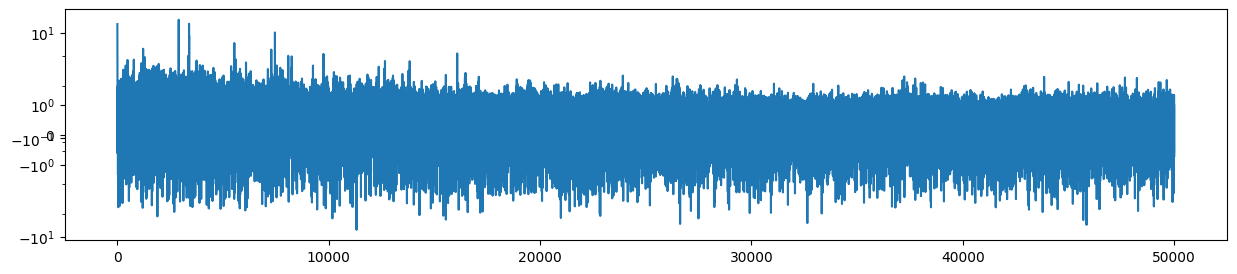

In [28]:
target_guide_fun = numpyro.infer.autoguide.AutoDiagonalNormal(model_funnel)
scheduler1_fun = optax.exponential_decay(
    init_value=0.5,
    decay_rate=0.99,
    transition_steps=100
)

optim_fun = optax.adabelief(learning_rate=scheduler1_fun)
loss_fun = numpyro.infer.RenyiELBO(alpha=-0.1, num_particles=100)
svi_fun = numpyro.infer.SVI(
    model_funnel,
    target_guide_fun,
    optim_fun,
    loss_fun
)
svi_results_fun = svi_fun.run(
    svi_key,
    50000,
    progress_bar=True,
    stable_update=True,
    dim=5
)

display(svi_results_fun.params)
plt.figure(figsize=(15, 3))
plt.plot(svi_results_fun.losses)
plt.gca().set_yscale('asinh');

In [30]:
temp_model_fun, potential_energy_fn_fun, sample_init_fn_fun, postprocessing_fn_fun, neg_elbo_fun = wrap_model(
    model_funnel,
    (),
    {'dim': 5},
    target_guide_fun,
    svi_results=svi_results_fun
)

In [31]:
mcmc_key, init_key, rng_key = jax.random.split(rng_key, 3)

In [32]:
unconstrained_init_params_fun = sample_init_fn_fun(init_key, svi_results_fun.params, num_chains)
unconstrained_init_params_fun

{'x': Array([[ 0.03222448,  0.48563457,  2.5094147 ,  1.4363645 ],
        [-2.2895265 ,  1.3457568 ,  1.8721334 ,  1.2798327 ],
        [ 1.4708399 ,  1.2849473 , -0.75409794,  1.1603029 ],
        [-2.1130302 ,  1.5888819 ,  1.3870211 , -2.5815806 ]],      dtype=float32),
 'y': Array([-2.1855245 ,  0.12471986, -1.177203  , -2.34381   ], dtype=float32),
 'temp_ctrl': Array([-20., -20., -20., -20.], dtype=float32)}

In [33]:
nuts_kernel_fun = numpyro.infer.NUTS(
    potential_fn=potential_energy_fn_fun,
    target_accept_prob=0.999,
    max_tree_depth=15,
    dense_mass=True
)

mcmc_fun = numpyro.infer.MCMC(
    nuts_kernel_fun,
    num_warmup=10000,
    num_samples=10000,
    num_chains=num_chains,
    chain_method='parallel',
    progress_bar=True,
    postprocess_fn=postprocessing_fn_fun
)
mcmc_fun.run(
    mcmc_key,
    init_params=unconstrained_init_params_fun
)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

[ 2  2  4 19]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,-0.668,23.627,-10.749,6.500,0.162,0.114,4655.0,2366.0,1.0
inv_temp,0.622,0.303,0.063,1.000,0.003,0.002,10850.0,13658.0,1.0
temp_ctrl,0.732,2.105,-3.328,4.719,0.020,0.014,10850.0,13658.0,1.0
w0,2.219,23.013,0.000,3.797,0.146,0.103,4654.0,2366.0,1.0
w1,2.887,4.127,0.000,6.880,0.058,0.041,4647.0,2366.0,1.0
x[0],0.032,1.632,-2.953,3.212,0.010,0.012,27981.0,16221.0,1.0
x[1],0.010,1.680,-3.068,3.308,0.010,0.013,26863.0,14887.0,1.0
x[2],-0.021,1.620,-3.003,3.021,0.010,0.014,28163.0,15165.0,1.0
x[3],-0.098,1.586,-3.182,2.672,0.010,0.012,27880.0,15830.0,1.0
y,-0.167,1.788,-3.720,3.122,0.036,0.032,2681.0,2025.0,1.0


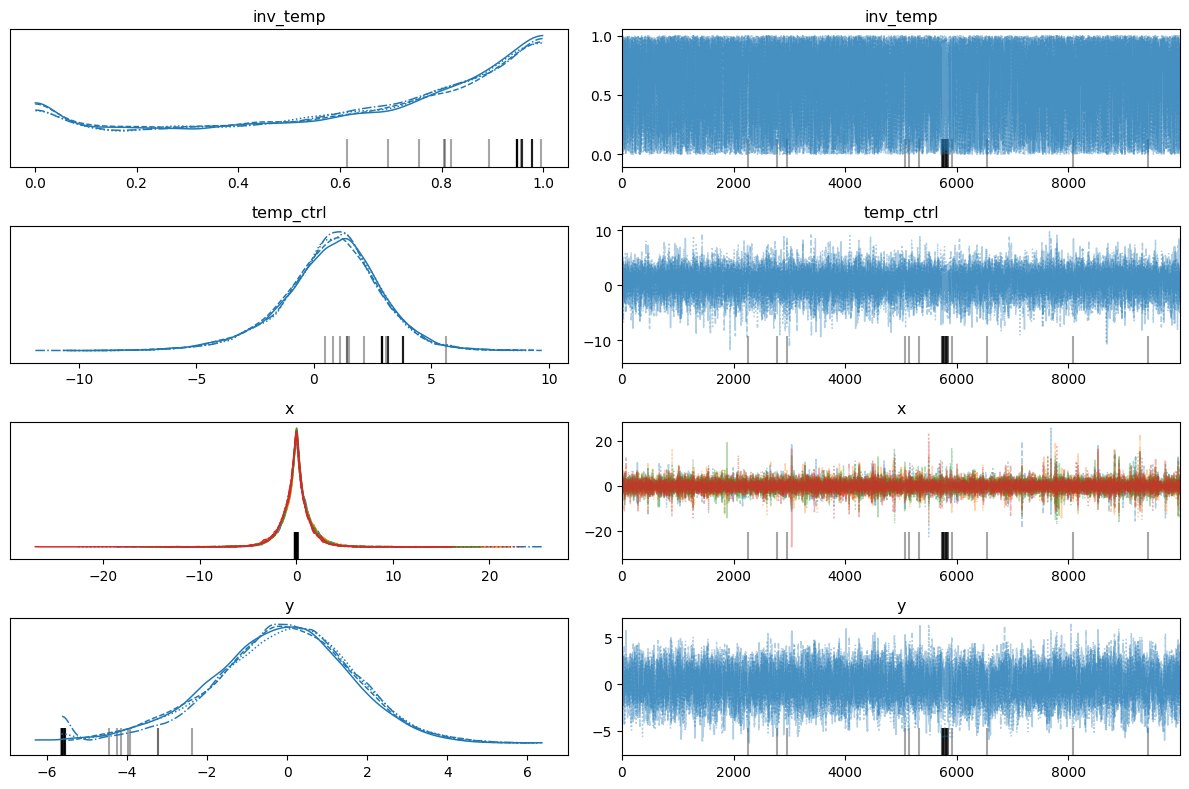

In [34]:
inf_data_fun = az.from_numpyro(mcmc_fun)

print(inf_data_fun.sample_stats.diverging.data.sum(axis=1))
display(az.summary(inf_data_fun))

az.plot_trace(inf_data_fun, var_names=['inv_temp', 'temp_ctrl', 'x', 'y'])
plt.tight_layout();

In [35]:
x_marginal_true = jnp.linspace(-10, 10, 1000)
y_marginal_true = jnp.exp(dist.Normal(0, 3).log_prob(x_marginal_true))

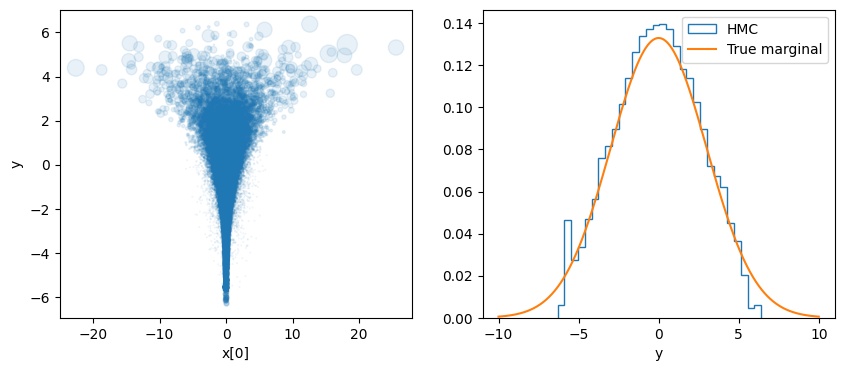

In [36]:
x_model = inf_data_fun.posterior.x[..., 0].data.flatten()
y_model = inf_data_fun.posterior.y.data.flatten()
w1 = inf_data_fun.posterior.w1.data.flatten()
w0 = inf_data_fun.posterior.w0.data.flatten()

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(x_model, y_model, s=w1+0.1, alpha=0.1)
plt.xlabel('x[0]')
plt.ylabel('y')
# plt.xlim(-100, 100)
# plt.ylim(-10, 10)

plt.subplot(122)
plt.hist(y_model, weights=w1, density=True, bins=30, histtype='step', label='HMC');
plt.plot(x_marginal_true, y_marginal_true, label='True marginal')
plt.xlabel('y')
plt.legend();

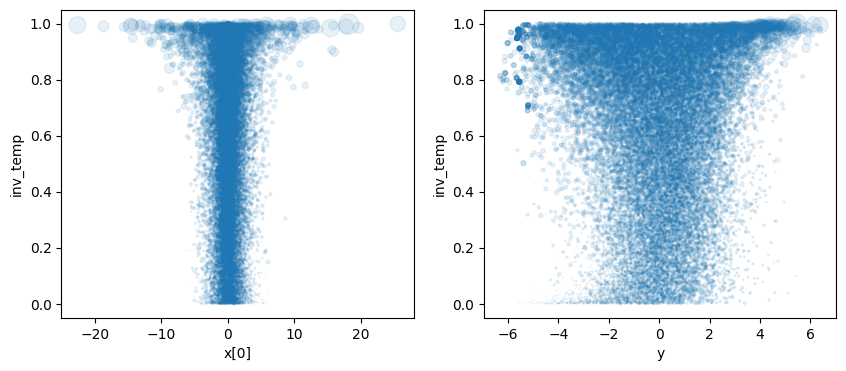

In [37]:
inv_temp = inf_data_fun.posterior.inv_temp.data.flatten()

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(x_model, inv_temp, s=w1+0.1, alpha=0.1)
plt.xlabel('x[0]')
plt.ylabel('inv_temp')
plt.subplot(122)
plt.scatter(y_model, inv_temp, s=w1+0.1, alpha=0.1)
plt.xlabel('y')
plt.ylabel('inv_temp');

In [38]:
neg_log_Z_fun = nlogZ(neg_elbo_fun, mcmc_fun.get_samples())
print(f'-log_Evidence: {neg_log_Z_fun}')
print(f'Evidence: {jnp.exp(-neg_log_Z_fun)}')

-log_Evidence: 0.05714988708496094
Evidence: 0.9444525241851807


## Iterate

In [39]:
new_params_fun, new_neg_elbo_fun  = re_center_guide(model_funnel, (), {'dim': 5}, mcmc_fun, target_guide_fun, neg_elbo_fun)
new_params_fun

{'auto_loc': Array([-0.09155599,  0.02937685, -0.07326476,  0.008029  ,  0.20026955],      dtype=float32),
 'auto_scale': Array([2.6400478, 3.2049074, 3.059695 , 3.1218648, 3.419582 ], dtype=float32)}

In [49]:
temp_model_fun_2, potential_energy_fn_fun_2, sample_init_fn_fun_2, postprocessing_fn_fun_2, neg_elbo_fun_2 = wrap_model(
    model_funnel,
    (),
    {'dim': 5},
    target_guide_fun,
    neg_elbo=new_neg_elbo_fun,
    guide_params=new_params_fun
)

In [50]:
mcmc_key, init_key, rng_key = jax.random.split(rng_key, 3)

In [51]:
unconstrained_init_params_fun_2 = sample_init_fn_fun_2(init_key, new_params_fun, num_chains)
unconstrained_init_params_fun_2

{'x': Array([[ 5.448367  ,  0.9750171 , -6.6282907 , -3.6597667 ],
        [-1.1125435 ,  2.8275409 ,  8.395277  ,  2.3527422 ],
        [-1.9569502 , -6.9797482 ,  9.862613  , -0.35406303],
        [-4.203646  ,  2.3043985 ,  5.3431325 ,  1.0654851 ]],      dtype=float32),
 'y': Array([ 2.614339 , -4.692973 ,  2.370246 ,  1.9594617], dtype=float32),
 'temp_ctrl': Array([-20., -20., -20., -20.], dtype=float32)}

In [52]:
nuts_kernel_fun_2 = numpyro.infer.NUTS(
    potential_fn=potential_energy_fn_fun_2,
    target_accept_prob=0.999,
    max_tree_depth=15,
    dense_mass=True
)

mcmc_fun_2 = numpyro.infer.MCMC(
    nuts_kernel_fun_2,
    num_warmup=10000,
    num_samples=10000,
    num_chains=num_chains,
    chain_method='parallel',
    progress_bar=True,
    postprocess_fn=postprocessing_fn_fun_2
)
mcmc_fun_2.run(
    mcmc_key,
    init_params=unconstrained_init_params_fun_2
)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

[ 6  2  3 14]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,0.064,18.026,-10.987,5.072,0.141,0.100,2896.0,2027.0,1.0
inv_temp,0.546,0.317,0.045,1.000,0.004,0.003,6401.0,8077.0,1.0
temp_ctrl,0.266,2.131,-3.788,4.208,0.026,0.019,6401.0,8077.0,1.0
w0,2.264,17.388,0.000,4.260,0.120,0.085,2896.0,2027.0,1.0
w1,2.200,3.743,0.000,7.119,0.065,0.046,2893.0,2027.0,1.0
x[0],0.039,3.640,-6.600,7.452,0.023,0.027,26590.0,17165.0,1.0
x[1],-0.008,3.909,-7.379,7.693,0.024,0.028,28890.0,18017.0,1.0
x[2],-0.011,4.307,-8.553,8.432,0.026,0.037,28986.0,18065.0,1.0
x[3],0.032,3.775,-7.155,7.304,0.023,0.026,28011.0,17445.0,1.0
y,1.728,1.925,-2.173,5.255,0.038,0.027,2782.0,1889.0,1.0


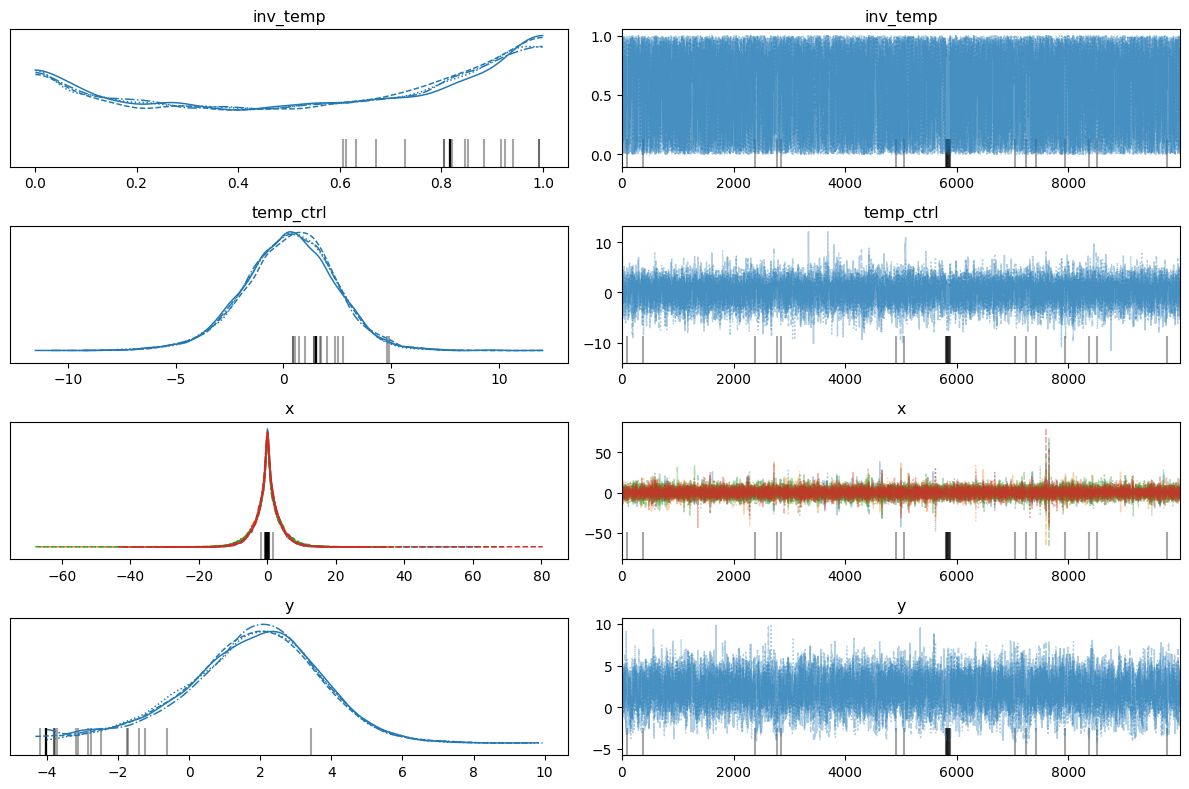

In [53]:
inf_data_fun_2 = az.from_numpyro(mcmc_fun_2)

print(inf_data_fun_2.sample_stats.diverging.data.sum(axis=1))
display(az.summary(inf_data_fun_2))

az.plot_trace(inf_data_fun_2, var_names=['inv_temp', 'temp_ctrl', 'x', 'y'])
plt.tight_layout();

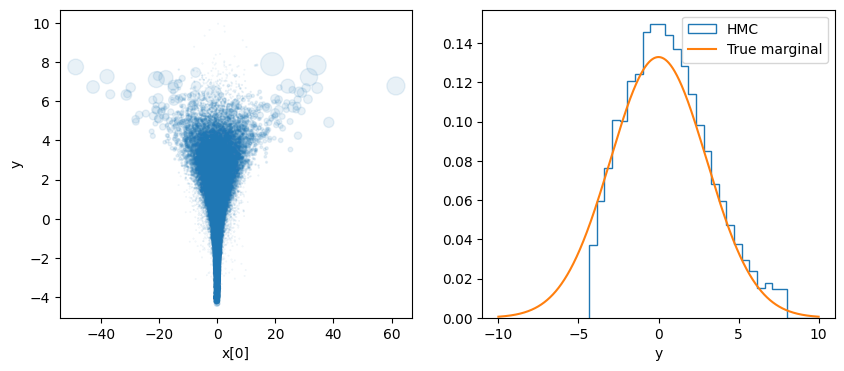

In [54]:
x_model = inf_data_fun_2.posterior.x[..., 0].data.flatten()
y_model = inf_data_fun_2.posterior.y.data.flatten()
w1 = inf_data_fun_2.posterior.w1.data.flatten()
w0 = inf_data_fun_2.posterior.w0.data.flatten()

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(x_model, y_model, s=w1+0.1, alpha=0.1)
plt.xlabel('x[0]')
plt.ylabel('y')
# plt.xlim(-100, 100)
# plt.ylim(-10, 10)

plt.subplot(122)
plt.hist(y_model, weights=w1, density=True, bins=30, histtype='step', label='HMC');
plt.plot(x_marginal_true, y_marginal_true, label='True marginal')
plt.xlabel('y')
plt.legend();

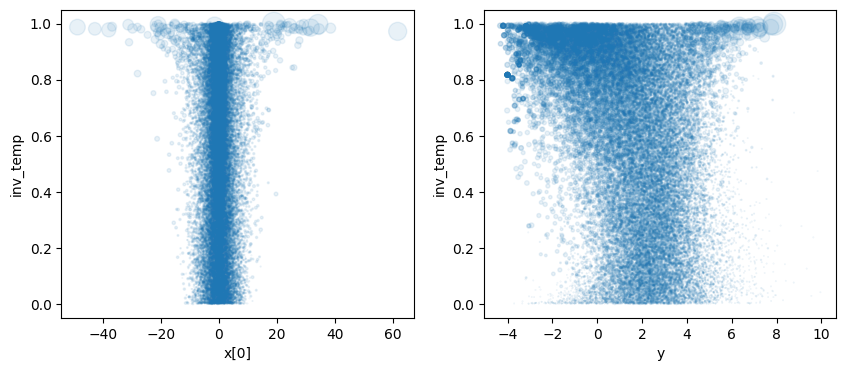

In [55]:
inv_temp = inf_data_fun_2.posterior.inv_temp.data.flatten()

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(x_model, inv_temp, s=w1+0.1, alpha=0.1)
plt.xlabel('x[0]')
plt.ylabel('inv_temp')
plt.subplot(122)
plt.scatter(y_model, inv_temp, s=w1+0.1, alpha=0.1)
plt.xlabel('y')
plt.ylabel('inv_temp');

In [56]:
neg_log_Z_fun_2 = nlogZ(neg_elbo_fun_2, mcmc_fun_2.get_samples())
print(f'-log_Evidence: {neg_log_Z_fun_2}')
print(f'Evidence: {jnp.exp(-neg_log_Z_fun_2)}')

-log_Evidence: -0.049859046936035156
Evidence: 1.0511229038238525
